# High-frequency Trading and Financial Market Volatility in the Modern Age

#### This project was created in the Spring of 2020 and was submitted as the final project for the Economics program's capstone course - Empirical Analysis at California State University - East Bay. The objective of this analysis was to determine if the proliferation of high-frequency trading has worked to destablize financial markets by increasing the volatility of intra-day prices of financial market indicies across two time periods. The first time period begins in the 1980s when the modern era of digital financial information began, the subsequent period began in the 2000s when computing power innovations fascilitated the rise of algorithmic and high-volume trading. I used a Bayesian Structural Time Series package from Google named CausalImpact to conduct this analysis which accepts a time series object, in this case the historical average price changes of the indicies, as well as an synthetic variable object to set our counter-factual and confidence interval, for this I used the percentage change in GDP over the same time periods of the respective indicies. The completed analysis can be found at:
https://www.linkedin.com/pulse/high-frequency-trading-financial-market-volatility-modern-escalante/

We begin by installing the necessary libraries.

In [2]:
library(quantmod)
library(xts)
library(readr)
library(CausalImpact)
library(ggplot2)
theme_set(theme_gray())
options(warn=0)

Using the Quantmod package allows us to pull data directly from various sources, including the Federal Reserve Economic Data repository (aka FRED). The percentage change in GDP is available to download directly, however the time periods that we need extend beyond what we can retrieve directly from FRED so we will download the raw data and calculate the percentage change ourselves.

In [4]:
gdp <- getSymbols("GDP", src="FRED", auto.assign=FALSE)
options("getSymbols.warning4.0"=FALSE)

The fortify() function converts the extendible time series (xts) object to a data frame, allowing us to conduct mathematical operations with the appropriate columns. Notice that the GDP information is reported quarterly, we will need monthly information but we can begin the process with the data as is.

In [5]:
gdp.df <- fortify(gdp)

In [6]:
head(gdp.df)

,Index,GDP
,<date>,<dbl>
1,1947-01-01,243.164
2,1947-04-01,245.968
3,1947-07-01,249.585
4,1947-10-01,259.745
5,1948-01-01,265.742
6,1948-04-01,272.567


To begin the percent change calculation we must first create a new column with the previous time period for that row. This will create a NULL value for our first observation in this new column so we will set this value to zero.

In [7]:
gdp.df$lag_1 <- Lag(gdp.df$GDP, k=1)
gdp.df$lag_1[1] <- 0

Here we create a numerical vector with the percentage change calculation.

In [8]:
pct.change <- (gdp.df$GDP - gdp.df$lag_1)/gdp.df$GDP*100

Now we can take that vector and convert it back to an xts object using the index from our data frame and the xts() function.

In [9]:
gdp.pct.ch <- xts(pct.change, gdp.df$Index)

In [10]:
head(gdp.pct.ch)

                Lag.1
1947-01-01 100.000000
1947-04-01   1.139986
1947-07-01   1.449206
1947-10-01   3.911529
1948-01-01   2.256700
1948-04-01   2.503972

Now we can plot this quarterly information to visualize the data.

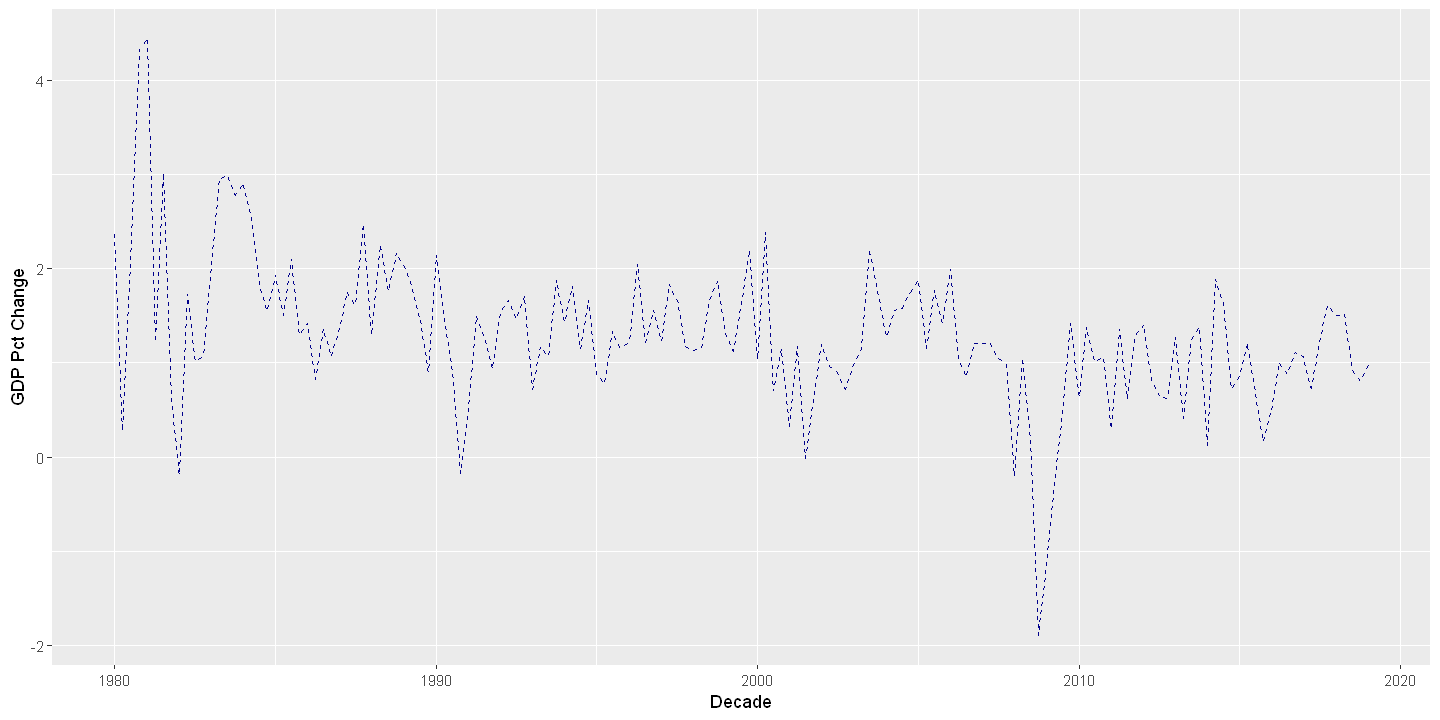

In [12]:
ggplot(gdp.pct.ch[133:289], aes(x=Index, y=Lag.1)) + theme_gray() + labs(x="Decade", y="GDP Pct Change") + geom_line(colour="darkblue", linetype = "dashed")
options(repr.plot.width=12, repr.plot.height=6)

Now we must convert this quarterly format to a monthly format so that we may column bind this data as our synthetic variable for each index. We begin by creating a 39-year vector with each item resprenting one month.

In [13]:
gdp.pct.mo <- c(1:468)

Here we subset the GDP % change data to the correct 39-year window.

In [14]:
pct.ch.num <- as.numeric(pct.change[133:289])

Now we create a custom function that takes each quarterly observation and appends the value to the new vector repeating the value for the respective 3 month period.

In [15]:
for (i in 1:156){
    for (j in 1:3){
        n=i*3-3
        gdp.pct.mo[n+j]=pct.ch.num[i]
    }
}

Looking at the first and last 21 observations we see that the quarterly values have been effectively converted to a vector that can be used with monthly data.

In [16]:
head(gdp.pct.mo, n=21)

[1] 2.3642558 2.3642558 2.3642558 0.2684682 0.2684682 0.2684682 2.0700631
 [8] 2.0700631 2.0700631 4.3232804 4.3232804 4.3232804 4.4378956 4.4378956
[15] 4.4378956 1.2118771 1.2118771 1.2118771 3.0079350 3.0079350 3.0079350

In [17]:
tail(gdp.pct.mo, n=21)

[1] 0.7316957 0.7316957 0.7316957 1.2135011 1.2135011 1.2135011 1.6083639
 [8] 1.6083639 1.6083639 1.5030569 1.5030569 1.5030569 1.5104522 1.5104522
[15] 1.5104522 0.9163214 0.9163214 0.9163214 0.7992883 0.7992883 0.7992883

### S&P 500 Data

For our first variable we will use the Standard and Poor's 500 Index beginning from January 1980 to December 2019. This version of the getSymbols() function allows us to pull data directly from Yahoo Finance and will give us various data points that we will use to create the variable we will use for our analysis.

In [18]:
sp500 <- getSymbols.yahoo('^GSPC', auto.assign=FALSE, from='1980-01-01',to='2019-12-31')

In [19]:
SP.df <- fortify(sp500)

In [20]:
head(SP.df)

,Index,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980-01-02,0,108.43,105.29,105.76,40610000,105.76
2,1980-01-03,0,106.08,103.26,105.22,50480000,105.22
3,1980-01-04,0,107.08,105.09,106.52,39130000,106.52
4,1980-01-07,0,107.80,105.80,106.81,44500000,106.81
5,1980-01-08,0,109.29,106.29,108.95,53390000,108.95
6,1980-01-09,0,111.09,108.41,109.05,65260000,109.05


For our analysis we will need to calculate the monthly intra-day percent price change average (MIDPPCA), where will take the daily high price and subtract the daily low price then divide the difference by the daily adjusted closing price, then average it on a monthly basis. This should give us an idea of how much the price is moving within each day over the course of a month, if volatility is dramatically increasing we will be able to pick up this trend over time. We will conduct the initial calculation and title it V for volatility.

In [21]:
SP.df$GSPC.V <- (SP.df$GSPC.High - SP.df$GSPC.Low)/ SP.df$GSPC.Adjusted

Now in order to convert the daily info to a monthly-average we must convert the data back to xts format.

In [22]:
SP.xts <- xts(SP.df$GSPC.V, SP.df$Index)

In [23]:
SP.xts <- apply.monthly(SP.xts, mean)

Now that we have our MIDPPCA variable we need to create a subset of the date index to use for the different indicies. The S&P 500 analysis has the broadest time period, from Janurary 1980 to December 2018, a total of 468 months.

In [24]:
SP.df.mo <- fortify(SP.xts[1:468])

In [25]:
index<- as.Date(SP.df.mo$Index[1:468])

Now we trim the last 12 months off the time series object.

In [26]:
SP.xts <- SP.xts[1:468]

Now we simply rename the variable and append our sythetic variable.

In [27]:
names(SP.xts)[1] <- "SP.MIDPPCA"
SP.xts$GDP <- xts(gdp.pct.mo, index)

In [29]:
head(SP.xts)
Sys.setenv(TZ = "UTC")

           SP.MIDPPCA       GDP
1980-01-31 0.02239846 2.3642558
1980-02-29 0.02371408 2.3642558
1980-03-31 0.02875209 2.3642558
1980-04-30 0.02281445 0.2684682
1980-05-30 0.01979930 0.2684682
1980-06-30 0.01932585 0.2684682

In [30]:
tail(SP.xts)

            SP.MIDPPCA       GDP
2018-07-31 0.006636440 0.9163214
2018-08-31 0.005622592 0.9163214
2018-09-28 0.005605107 0.9163214
2018-10-31 0.017035457 0.7992883
2018-11-30 0.013574112 0.7992883
2018-12-31 0.025289338 0.7992883

The final step before running the BSTS algorithm is to define the periods before and after the event that would create the expected change we are analyzing. These variable must have a vector with two items: the beginning date and ending date of the time period in question. These items must be in POSIXct date data type in order to be accepted in the CausalImpact package.

In [31]:
pre.period.SP <- as.POSIXct(c('1980-01-31','1999-12-31'))
post.period.SP <- as.POSIXct(c('2000-01-31', '2018-12-31'))

Now we simply plug in our xts object along with the pre and post period date objects and plot the model.

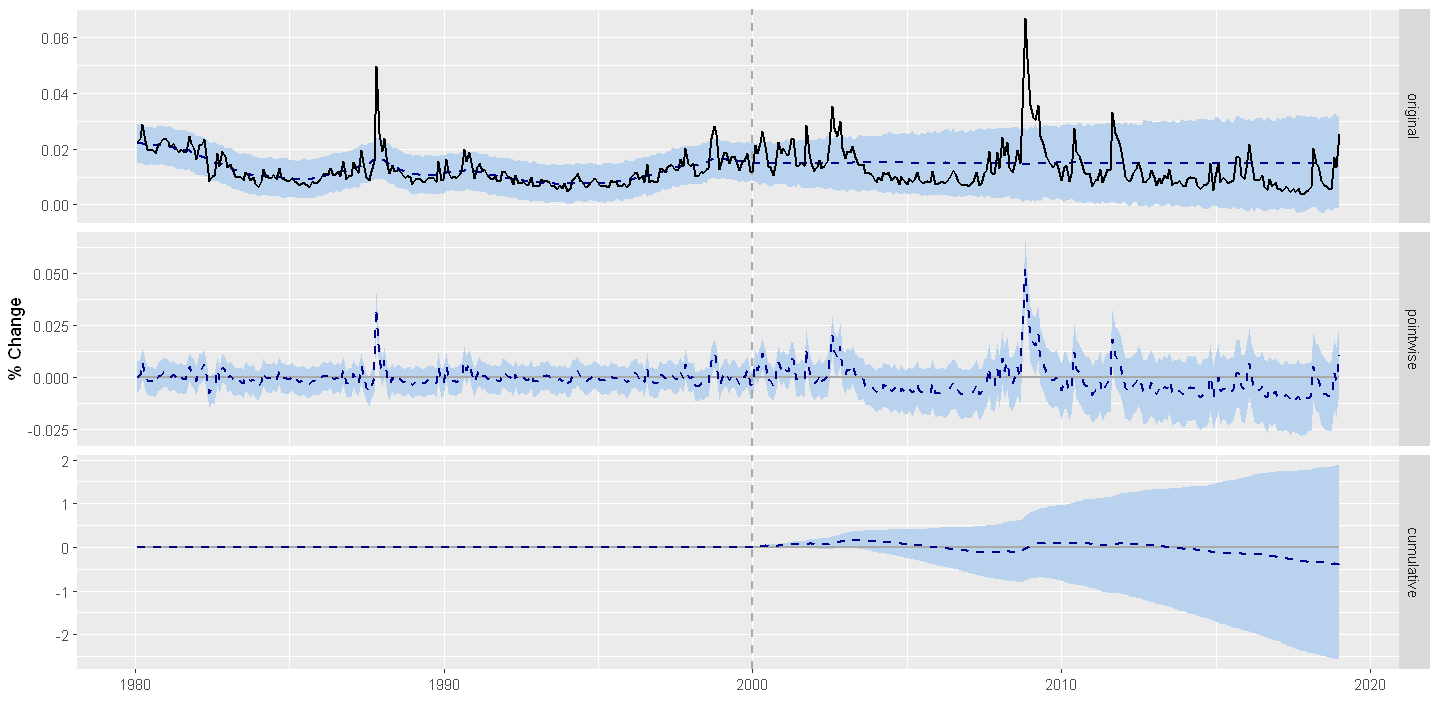

In [32]:
model.SP <- CausalImpact(SP.xts, pre.period.SP, post.period.SP)
plot(model.SP) + theme_gray() + labs(X="Decade", y="% Change")
options(repr.plot.width=12, repr.plot.height=8)

The CausalImpact package produces a detailed summary which includes both the boundaries of the average and cumulative intervals, along with a verbose written analysis.

In [33]:
summary(model.SP)

Posterior inference {CausalImpact}

                         Average            Cumulative      
Actual                   0.013              3.027           
Prediction (s.d.)        0.015 (0.0048)     3.397 (1.0879)  
95% CI                   [0.005, 0.025]     [1.136, 5.592]  
                                                            
Absolute effect (s.d.)   -0.0016 (0.0048)   -0.3694 (1.0879)
95% CI                   [-0.011, 0.0083]   [-2.564, 1.8915]
                                                            
Relative effect (s.d.)   -11% (32%)         -11% (32%)      
95% CI                   [-75%, 56%]        [-75%, 56%]     

Posterior tail-area probability p:   0.35985
Posterior prob. of a causal effect:  64%

For more details, type: summary(impact, "report")



In [34]:
summary(model.SP, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 0.013. In the absence of an intervention, we would have expected an average response of 0.015. The 95% interval of this counterfactual prediction is [0.0050, 0.025]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -0.0016 with a 95% interval of [-0.011, 0.0083]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 3.03. Had the intervention not taken place, we would have expected a sum of 3.40. The 95% interval of this prediction is [1.14, 5.59].

The above results are given in terms of absolute numbers. In relative terms, the response variable showed a decrease of -11%. T

### Dow Jones Data

We will repeat the process with the data from the Dow Jones Industrial Index with a few necessary changes.

In [35]:
DJI <- getSymbols.yahoo('^DJI', auto.assign=FALSE, from='1980-01-01',to='2018-12-31')

Viewing what was downloaded from Yahoo Finance we see that daily data from before 1992 is not included, this means we will have to be mindfull of how we line up our dates moving foreward.

In [36]:
DJI.df <- fortify(DJI)
head(DJI.df)

,Index,DJI.Open,DJI.High,DJI.Low,DJI.Close,DJI.Volume,DJI.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1992-01-02,3152.1,3172.63,3139.31,3172.4,23550000,3172.4
2,1992-01-03,3172.4,3210.64,3165.92,3201.5,23620000,3201.5
3,1992-01-06,3201.5,3213.33,3191.86,3200.1,27280000,3200.1
4,1992-01-07,3200.1,3210.20,3184.48,3204.8,25510000,3204.8
5,1992-01-08,3204.8,3229.20,3185.82,3203.9,29040000,3203.9
6,1992-01-09,3203.9,3228.31,3192.75,3209.5,29820000,3209.5


In [37]:
tail(DJI.df)

,Index,DJI.Open,DJI.High,DJI.Low,DJI.Close,DJI.Volume,DJI.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6795,2018-12-20,23224.12,23282.20,22644.31,22859.60,576700000,22859.60
6796,2018-12-21,22871.74,23254.59,22396.34,22445.37,900510000,22445.37
6797,2018-12-24,22317.28,22339.87,21792.20,21792.20,308420000,21792.20
6798,2018-12-26,21857.73,22878.92,21712.53,22878.45,433080000,22878.45
6799,2018-12-27,22629.06,23138.89,22267.42,23138.82,407940000,23138.82
6800,2018-12-28,23213.61,23381.88,22981.33,23062.40,336510000,23062.40


Now we begin the process of creating our MIDPPCA variable by finding the daily volatility.

In [38]:
DJI.df$DJI.V <- (DJI.df$DJI.High - DJI.df$DJI.Low)/ DJI.df$DJI.Adjusted

In [39]:
head(DJI.df)

,Index,DJI.Open,DJI.High,DJI.Low,DJI.Close,DJI.Volume,DJI.Adjusted,DJI.V
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1992-01-02,3152.1,3172.63,3139.31,3172.4,23550000,3172.4,0.010503034
2,1992-01-03,3172.4,3210.64,3165.92,3201.5,23620000,3201.5,0.013968443
3,1992-01-06,3201.5,3213.33,3191.86,3200.1,27280000,3200.1,0.006709156
4,1992-01-07,3200.1,3210.20,3184.48,3204.8,25510000,3204.8,0.008025453
5,1992-01-08,3204.8,3229.20,3185.82,3203.9,29040000,3203.9,0.013539712
6,1992-01-09,3203.9,3228.31,3192.75,3209.5,29820000,3209.5,0.011079626


In [40]:
tail(DJI.df)

,Index,DJI.Open,DJI.High,DJI.Low,DJI.Close,DJI.Volume,DJI.Adjusted,DJI.V
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6795,2018-12-20,23224.12,23282.20,22644.31,22859.60,576700000,22859.60,0.02790463
6796,2018-12-21,22871.74,23254.59,22396.34,22445.37,900510000,22445.37,0.03823729
6797,2018-12-24,22317.28,22339.87,21792.20,21792.20,308420000,21792.20,0.02513147
6798,2018-12-26,21857.73,22878.92,21712.53,22878.45,433080000,22878.45,0.05098207
6799,2018-12-27,22629.06,23138.89,22267.42,23138.82,407940000,23138.82,0.03766271
6800,2018-12-28,23213.61,23381.88,22981.33,23062.40,336510000,23062.40,0.01736813


We convert back to xts data type in order to produce monthly averages.

In [41]:
DJI.xts <- xts(DJI.df$DJI.V, DJI.df$Index)

In [42]:
head(DJI.xts)

                  [,1]
1992-01-02 0.010503034
1992-01-03 0.013968443
1992-01-06 0.006709156
1992-01-07 0.008025453
1992-01-08 0.013539712
1992-01-09 0.011079626

In [43]:
tail(DJI.xts)

                 [,1]
2018-12-20 0.02790463
2018-12-21 0.03823729
2018-12-24 0.02513147
2018-12-26 0.05098207
2018-12-27 0.03766271
2018-12-28 0.01736813

In [44]:
DJI.xts <- apply.monthly(DJI.xts, mean)

Here we rename our variable feature and line up the the appropriate months from the synthetic variable, which begins in Janurary 1980, 145 months before our Dow Jones data. 

In [45]:
names(DJI.xts)[1] <- "DJI.MIDPPCA"
DJI.xts$GDP <- xts(gdp.pct.mo[145:468], index[145:468])

In [46]:
head(DJI.xts)

           DJI.MIDPPCA      GDP
1992-01-31 0.011376414 1.548961
1992-02-28 0.010951118 1.548961
1992-03-31 0.008241389 1.548961
1992-04-30 0.011253540 1.663807
1992-05-29 0.009039687 1.663807
1992-06-30 0.008274832 1.663807

Viewing the tail of this object we see that we have generated NA values which we will drop from the analysis.

In [47]:
tail(DJI.xts)

           DJI.MIDPPCA       GDP
2018-08-31 0.006334317 0.9163214
2018-09-28 0.006728839 0.9163214
2018-10-31 0.017060699 0.7992883
2018-11-30 0.014171265 0.7992883
2018-12-28 0.026286176        NA
2018-12-31          NA 0.7992883

In [48]:
DJI.xts<-na.omit(DJI.xts)

In [49]:
tail(DJI.xts)

           DJI.MIDPPCA       GDP
2018-06-29 0.008267641 1.5104522
2018-07-31 0.007154422 0.9163214
2018-08-31 0.006334317 0.9163214
2018-09-28 0.006728839 0.9163214
2018-10-31 0.017060699 0.7992883
2018-11-30 0.014171265 0.7992883

Now we just have to be sure to include the correct start and stop date for the pre-period and run the algorithm as we did before.

In [50]:
pre.period.DJI <- as.POSIXct(c('1992-01-31','1999-12-31'))
post.period.DJI <- as.POSIXct(c('2000-01-31', '2018-11-30'))

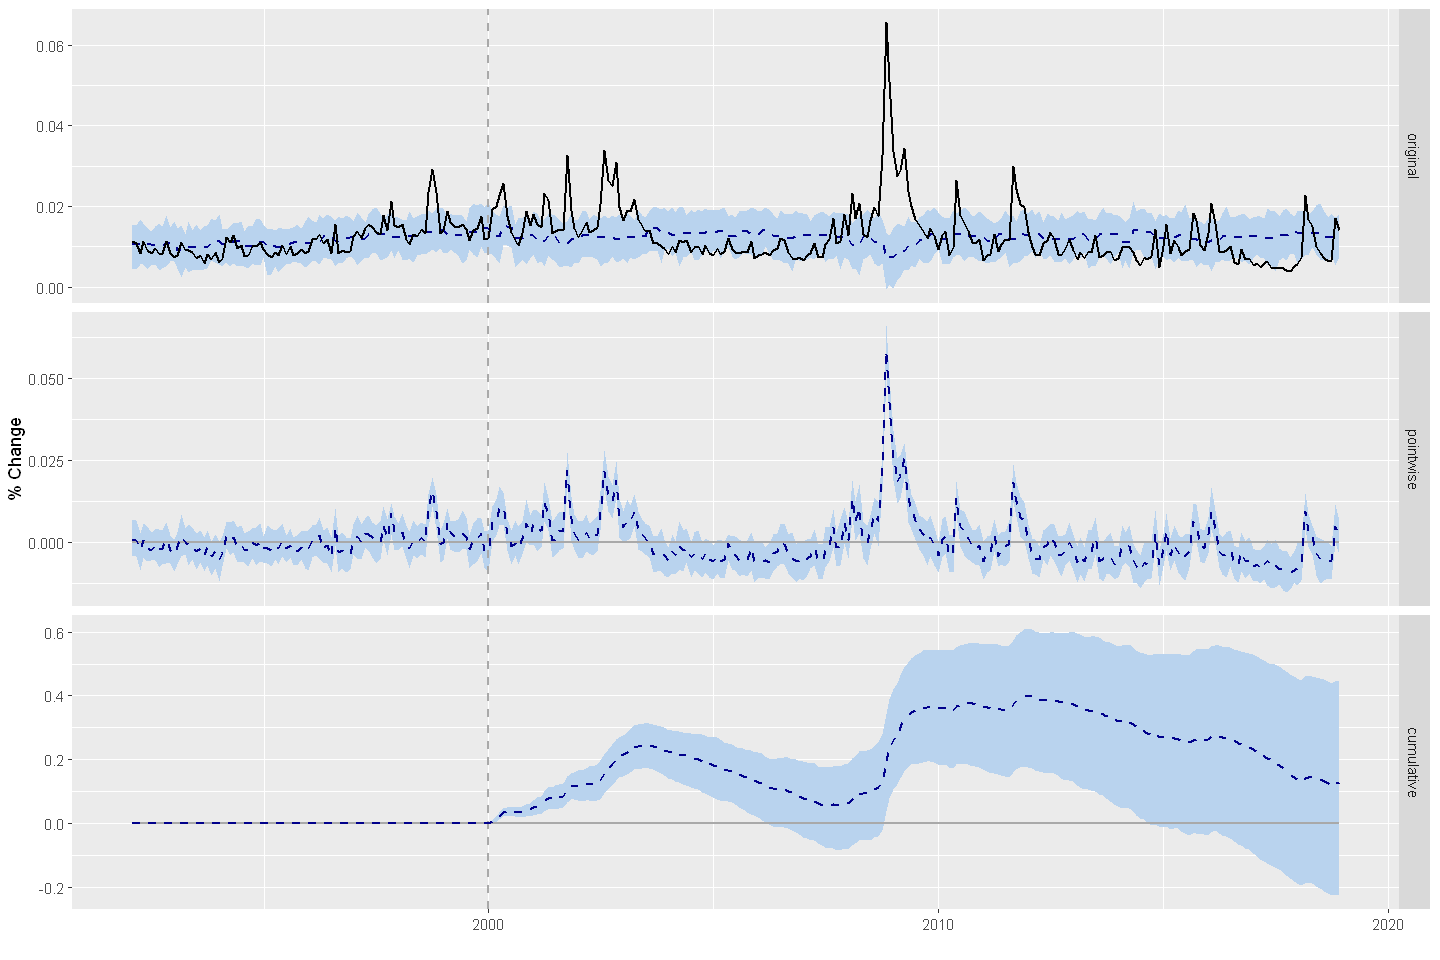

In [51]:
model.DJI <- CausalImpact(DJI.xts, pre.period.DJI, post.period.DJI)
plot(model.DJI) + theme_gray() + labs(X="Decade", y="% Change")
options(repr.plot.width=12, repr.plot.height=8)

In [52]:
summary(model.DJI)

Posterior inference {CausalImpact}

                         Average             Cumulative       
Actual                   0.013               2.945            
Prediction (s.d.)        0.012 (0.00087)     2.817 (0.19818)  
95% CI                   [0.011, 0.014]      [2.496, 3.169]   
                                                              
Absolute effect (s.d.)   0.00056 (0.00087)   0.12820 (0.19818)
95% CI                   [-0.00099, 0.002]   [-0.22399, 0.449]
                                                              
Relative effect (s.d.)   4.6% (7%)           4.6% (7%)        
95% CI                   [-8%, 16%]          [-8%, 16%]       

Posterior tail-area probability p:   0.26087
Posterior prob. of a causal effect:  74%

For more details, type: summary(impact, "report")



In [53]:
summary(model.DJI, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 0.013. In the absence of an intervention, we would have expected an average response of 0.012. The 95% interval of this counterfactual prediction is [0.011, 0.014]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 0.00056 with a 95% interval of [-0.00099, 0.0020]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 2.95. Had the intervention not taken place, we would have expected a sum of 2.82. The 95% interval of this prediction is [2.50, 3.17].

The above results are given in terms of absolute numbers. In relative terms, the response variable showed an increase of +5%. 

### Nasdaq Data

We finish this project with the Nasdaq Composite Index.

In [54]:
nasdaq <- getSymbols.yahoo('^IXIC', auto.assign=FALSE, from='1980-01-01',to='2018-12-31')
options("getSymbols.warning4.0"=FALSE)

Viewing the data we see a new problem with the data from Yahoo Finance, the first few years of the data only shows one number for the various price features which would make it difficult to try and calculate our MIDPPCA variable.

In [55]:
NDAQ.df <- fortify(nasdaq)
head(NDAQ.df)

,Index,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980-01-02,148.17,148.17,148.17,148.17,0,148.17
2,1980-01-03,145.97,145.97,145.97,145.97,0,145.97
3,1980-01-04,148.02,148.02,148.02,148.02,0,148.02
4,1980-01-07,148.62,148.62,148.62,148.62,0,148.62
5,1980-01-08,150.68,150.68,150.68,150.68,0,150.68
6,1980-01-09,151.60,151.60,151.60,151.60,0,151.60


In [56]:
tail(NDAQ.df)

,Index,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9829,2018-12-20,6607.76,6666.20,6447.91,6528.41,3258090000,6528.41
9830,2018-12-21,6573.49,6586.68,6304.63,6332.99,4534120000,6332.99
9831,2018-12-24,6278.49,6355.18,6190.17,6192.92,1647270000,6192.92
9832,2018-12-26,6257.86,6555.53,6214.34,6554.36,2558940000,6554.36
9833,2018-12-27,6457.19,6583.01,6336.97,6579.49,2415870000,6579.49
9834,2018-12-28,6616.79,6684.18,6529.22,6584.52,2199090000,6584.52


In creating the Volatility column we notice that the calculation yields zeroes for the first n observations, this may effect our analysis so we must find n.

In [57]:
NDAQ.df$IXIC.V <- (NDAQ.df$IXIC.High - NDAQ.df$IXIC.Low)/NDAQ.df$IXIC.Adjusted

In [58]:
head(NDAQ.df)

,Index,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted,IXIC.V
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980-01-02,148.17,148.17,148.17,148.17,0,148.17,0
2,1980-01-03,145.97,145.97,145.97,145.97,0,145.97,0
3,1980-01-04,148.02,148.02,148.02,148.02,0,148.02,0
4,1980-01-07,148.62,148.62,148.62,148.62,0,148.62,0
5,1980-01-08,150.68,150.68,150.68,150.68,0,150.68,0
6,1980-01-09,151.60,151.60,151.60,151.60,0,151.60,0


In [59]:
which(NDAQ.df$IXIC.V == 0)

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14
  [15]   15   16   17   18   19   20   21   22   23   24   25   26   27   28
  [29]   29   30   31   32   33   34   35   36   37   38   39   40   41   42
  [43]   43   44   45   46   47   48   49   50   51   52   53   54   55   56
  [57]   57   58   59   60   61   62   63   64   65   66   67   68   69   70
  [71]   71   72   73   74   75   76   77   78   79   80   81   82   83   84
  [85]   85   86   87   88   89   90   91   92   93   94   95   96   97   98
  [99]   99  100  101  102  103  104  105  106  107  108  109  110  111  112
 [113]  113  114  115  116  117  118  119  120  121  122  123  124  125  126
 [127]  127  128  129  130  131  132  133  134  135  136  137  138  139  140
 [141]  141  142  143  144  145  146  147  148  149  150  151  152  153  154
 [155]  155  156  157  158  159  160  161  162  163  164  165  166  167  168
 [169]  169  170  171  172  173  174  175  176  177  178  179  180  181  182
 [183]  183  184  185  186  187  188  189  190  191  192  193  194  195  196
 [197]  197  198  199  200  201  202  203  204  205  206  207  208  209  210
 [211]  211  212  213  214  215  216  217  218  219  220  221  222  223  224
 [225]  225  226  227  228  229  230  231  232  233  234  235  236  237  238
 [239]  239  240  241  242  243  244  245  246  247  248  249  250  251  252
 [253]  253  254  255  256  257  258  259  260  261  262  263  264  265  266
 [267]  267  268  269  270  271  272  273  274  275  276  277  278  279  280
 [281]  281  282  283  284  285  286  287  288  289  290  291  292  293  294
 [295]  295  296  297  298  299  300  301  302  303  304  305  306  307  308
 [309]  309  310  311  312  313  314  315  316  317  318  319  320  321  322
 [323]  323  324  325  326  327  328  329  330  331  332  333  334  335  336
 [337]  337  338  339  340  341  342  343  344  345  346  347  348  349  350
 [351]  351  352  353  354  355  356  357  358  359  360  361  362  363  364
 [365]  365  366  367  368  369  370  371  372  373  374  375  376  377  378
 [379]  379  380  381  382  383  384  385  386  387  388  389  390  391  392
 [393]  393  394  395  396  397  398  399  400  401  402  403  404  405  406
 [407]  407  408  409  410  411  412  413  414  415  416  417  418  419  420
 [421]  421  422  423  424  425  426  427  428  429  430  431  432  433  434
 [435]  435  436  437  438  439  440  441  442  443  444  445  446  447  448
 [449]  449  450  451  452  453  454  455  456  457  458  459  460  461  462
 [463]  463  464  465  466  467  468  469  470  471  472  473  474  475  476
 [477]  477  478  479  480  481  482  483  484  485  486  487  488  489  490
 [491]  491  492  493  494  495  496  497  498  499  500  501  502  503  504
 [505]  505  506  507  508  509  510  511  512  513  514  515  516  517  518
 [519]  519  520  521  522  523  524  525  526  527  528  529  530  531  532
 [533]  533  534  535  536  537  538  539  540  541  542  543  544  545  546
 [547]  547  548  549  550  551  552  553  554  555  556  557  558  559  560
 [561]  561  562  563  564  565  566  567  568  569  570  571  572  573  574
 [575]  575  576  577  578  579  580  581  582  583  584  585  586  587  588
 [589]  589  590  591  592  593  594  595  596  597  598  599  600  601  602
 [603]  603  604  605  606  607  608  609  610  611  612  613  614  615  616
 [617]  617  618  619  620  621  622  623  624  625  626  627  628  629  630
 [631]  631  632  633  634  635  636  637  638  639  640  641  642  643  644
 [645]  645  646  647  648  649  650  651  652  653  654  655  656  657  658
 [659]  659  660  661  662  663  664  665  666  667  668  669  670  671  672
 [673]  673  674  675  676  677  678  679  680  681  682  683  684  685  686
 [687]  687  688  689  690  691  692  693  694  695  696  697  698  699  700
 [701]  701  702  703  704  705  706  707  708  709  710  711  712  713  714
 [715]  715  716  717  718  719  720  721  722  723  724  725  726  727  728

In [60]:
NDAQ.df$Index[1210]

[1] "1984-10-11"

In [61]:
nrow(NDAQ.df)

[1] 9834

We can see that the first 1209 consecutive observations are all zero, we can asssume that the 1210th observation is where the data for individual features began to be recorded - the other days it is safe to assume that the volatility measure equaling zero coincidental. We will subset our data set to begin on the 1210th observation, and continue the analysis like we did before.

In [62]:
NDAQ.df.sub <- NDAQ.df[1210:9834,]

In [63]:
NDAQ.xts <- xts(NDAQ.df.sub$IXIC.V, NDAQ.df.sub$Index)

In [64]:
NDAQ.xts <- apply.monthly(NDAQ.xts, mean)
names(NDAQ.xts)[1] <- "NDAQ.MIDPPCA"

In [65]:
head(NDAQ.xts)

           NDAQ.MIDPPCA
1984-10-31  0.003164435
1984-11-30  0.005337882
1984-12-31  0.006691112
1985-01-31  0.004319085
1985-02-28  0.003521892
1985-03-29  0.005248618

In [66]:
nrow(NDAQ.xts)

[1] 411

To simplify the time periods we will omit the 1984 observations of the converted monthly MIDPPCA variable.

In [67]:
NDAQ.xts <- NDAQ.xts[4:411]

In [68]:
head(NDAQ.xts)

           NDAQ.MIDPPCA
1985-01-31  0.004319085
1985-02-28  0.003521892
1985-03-29  0.005248618
1985-04-30  0.004752145
1985-05-31  0.004678505
1985-06-28  0.004700948

In appending the % change GDP variable we will drop the first five years, or 60 months, to line up with our subsetted data starting in Janurary 1985.

In [69]:
NDAQ.xts$GDP <- xts(gdp.pct.mo[61:468], index[61:468])

In [70]:
head(NDAQ.xts)

           NDAQ.MIDPPCA      GDP
1985-01-31  0.004319085 1.929403
1985-02-28  0.003521892 1.929403
1985-03-29  0.005248618 1.929403
1985-04-30  0.004752145 1.506885
1985-05-31  0.004678505 1.506885
1985-06-28  0.004700948 1.506885

Examining the tail end of our data set we see that we have generated NA values just as we did with the Dow Jones MIDPPCA variable. We will drop these observations as well.

In [71]:
tail(NDAQ.xts)

           NDAQ.MIDPPCA       GDP
2018-08-31  0.007539192 0.9163214
2018-09-28  0.009414664 0.9163214
2018-10-31  0.022307585 0.7992883
2018-11-30  0.017780580 0.7992883
2018-12-28  0.028928104        NA
2018-12-31           NA 0.7992883

In [72]:
NDAQ.xts <- na.omit(NDAQ.xts)

In [73]:
tail(NDAQ.xts)

           NDAQ.MIDPPCA       GDP
2018-06-29  0.009838547 1.5104522
2018-07-31  0.010546254 0.9163214
2018-08-31  0.007539192 0.9163214
2018-09-28  0.009414664 0.9163214
2018-10-31  0.022307585 0.7992883
2018-11-30  0.017780580 0.7992883

Being careful to line up our start/stop dates for both periods we run the algorithm just as we did before.

In [74]:
pre.period.NDAQ <- as.POSIXct(c('1985-01-31','1999-12-31'))
post.period.NDAQ <- as.POSIXct(c('2000-01-31', '2018-11-30'))

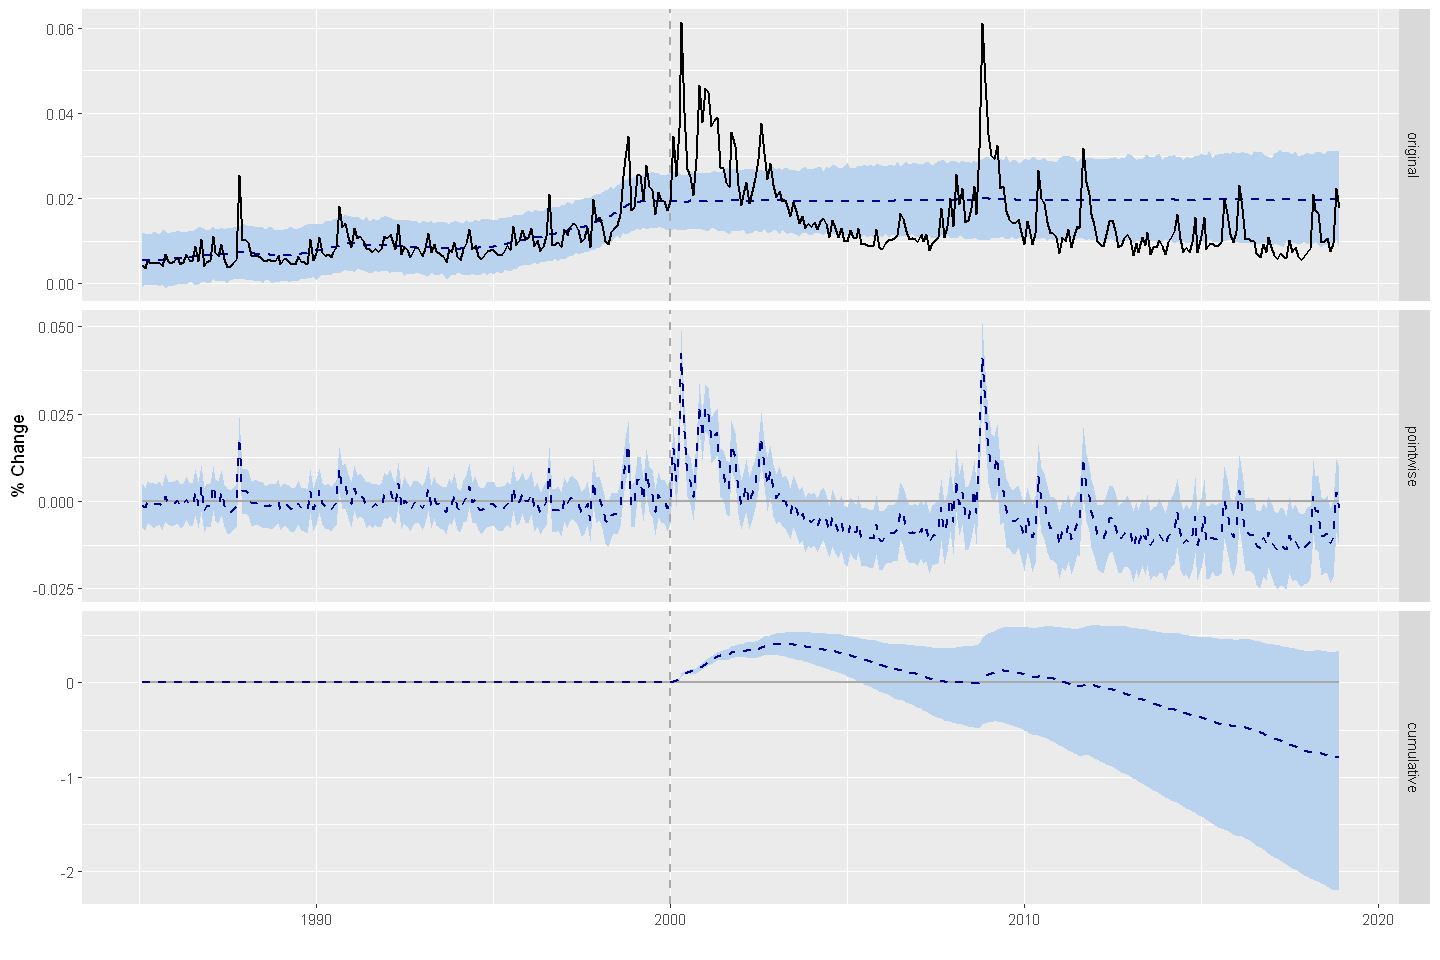

In [75]:
model.NDAQ <- CausalImpact(NDAQ.xts, pre.period.NDAQ, post.period.NDAQ)
plot(model.NDAQ) + theme_gray() + labs(X="Decade", y="% Change")
options(repr.plot.width=12, repr.plot.height=8)

In [76]:
summary(model.NDAQ)

Posterior inference {CausalImpact}

                         Average             Cumulative       
Actual                   0.016               3.650            
Prediction (s.d.)        0.02 (0.0029)       4.44 (0.6581)    
95% CI                   [0.015, 0.026]      [3.315, 5.852]   
                                                              
Absolute effect (s.d.)   -0.0035 (0.0029)    -0.7928 (0.6581) 
95% CI                   [-0.0097, 0.0015]   [-2.2021, 0.3352]
                                                              
Relative effect (s.d.)   -18% (15%)          -18% (15%)       
95% CI                   [-50%, 7.5%]        [-50%, 7.5%]     

Posterior tail-area probability p:   0.10867
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



In [77]:
summary(model.NDAQ, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 0.016. In the absence of an intervention, we would have expected an average response of 0.020. The 95% interval of this counterfactual prediction is [0.015, 0.026]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -0.0035 with a 95% interval of [-0.0097, 0.0015]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 3.65. Had the intervention not taken place, we would have expected a sum of 4.44. The 95% interval of this prediction is [3.31, 5.85].

The above results are given in terms of absolute numbers. In relative terms, the response variable showed a decrease of -18%. T